In [1]:
%matplotlib ipympl
import os
import os.path as path
import logging, sys
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [5]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [8]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof, max_mc = wd.dataset_tdc_selection()
display(tdc, det_diam, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

FloatText(value=78.0, description='Detector diameter:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=54.0, description='t0:')

$$\textbf{You can specify which dataset to use in below block}$$

In [9]:


dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()
# variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.dirname(dataset_main_path) +  '/tof_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc.value == 'leap_pos' or tdc.value == 'leap_epos':
    if tdc.value == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        print('The file has to be epos. With pos information this tutorial cannot be run')
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)


In [10]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,58.919978,59.590457,3154.404053,3154.404053,51225.0,1146.088386,0.0,0.203755,-1.079265,0,1
1,0.0,0.0,0.0,59.357073,60.230824,3154.404053,3154.404053,51305.0,1149.435090,0.0,-0.095510,-0.799102,80,1
2,0.0,0.0,0.0,59.961986,60.591436,3154.404053,3154.404053,51399.0,1158.371064,0.0,-0.012735,-1.378531,94,1
3,0.0,0.0,0.0,61.130971,62.235298,3154.404053,3154.404053,51448.0,1190.768256,0.0,1.177959,2.091673,49,1
4,0.0,0.0,0.0,59.835971,61.049516,3154.404053,3154.404053,51455.0,1178.602164,0.0,0.897796,2.161714,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682356,0.0,0.0,0.0,61.045645,61.973033,5310.980957,5310.980957,55949.0,912.518622,0.0,-0.646286,-0.993306,435,1
1682357,0.0,0.0,0.0,59.630666,61.505565,5310.980957,5310.980957,56135.0,935.582076,0.0,-3.005388,-0.006367,186,1
1682358,0.0,0.0,0.0,61.028288,62.860240,5310.980957,5310.980957,56565.0,926.783262,0.0,-1.846531,0.547592,430,1
1682359,0.0,0.0,0.0,61.376760,61.160990,5310.980957,5310.980957,57092.0,926.193474,0.0,2.317714,-1.276653,527,1


In [11]:
# Remove negative TOF
# threshold = 0
# dld_t_mask = data['t (ns)'].to_numpy()
# dld_t_mask = (dld_t <= threshold)
# data.drop(np.where(dld_t_mask)[0], inplace=True)
# data.reset_index(inplace=True, drop=True)


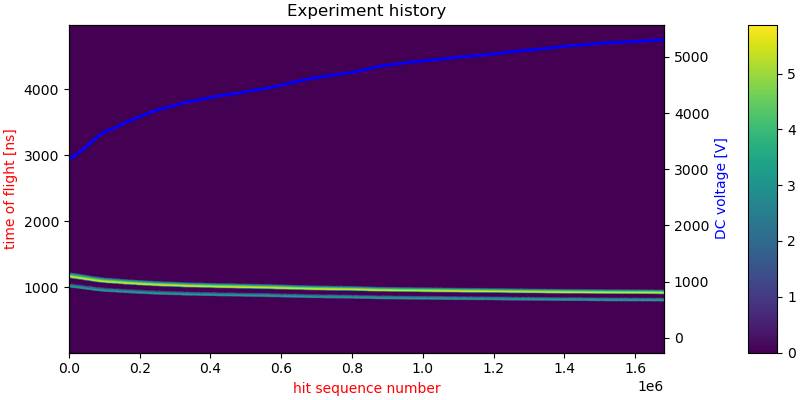

In [12]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [17]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
variables.dld_t_calib_backup = np.copy(dld_t)

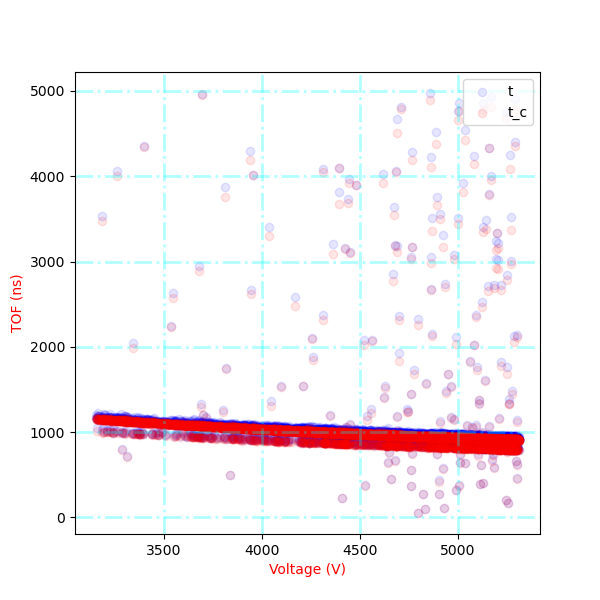

In [19]:
ion_distance = np.sqrt(flightPathLength_d.value**2 + (dld_x*10)**2 + (dld_y*10)**2)
ion_distance = flightPathLength_d.value / ion_distance
dld_t_c = dld_t * ion_distance

# mask_t = np.logical_and((dld_t < 800),( dld_t > 600))
# mask_t_c = np.logical_and((dld_t_c < 800),( dld_t_c > 600))
# mask_t = np.logical_and(mask_t, mask_t_c)

dld_t_p = dld_t[:]
dld_t_p_c = dld_t_c[:]


dld_highVoltage_p = dld_highVoltage[:]
dld_highVoltage_p_c = dld_highVoltage[:]

fig1, ax1 = plt.subplots(figsize=(6, 6))
mask = np.random.randint(0, len(dld_t_p), 10000)

x = plt.scatter( dld_highVoltage_p[mask], dld_t_p[mask], color="blue",
                label='t', alpha=0.1)
y = plt.scatter(dld_highVoltage_p_c[mask], dld_t_p_c[mask], color="red",
                label='t_c', alpha=0.1)

# dld_t_p_c_2 = dld_t_c_2[mask_t]
# z = plt.scatter(dld_highVoltage_p_c[mask], dld_t_p_c_2[mask], color="black",
#                 label='t_c_2', alpha=0.1)

ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
ax1.set_ylabel("TOF (ns)", color="red", fontsize=10)

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(loc='upper right')

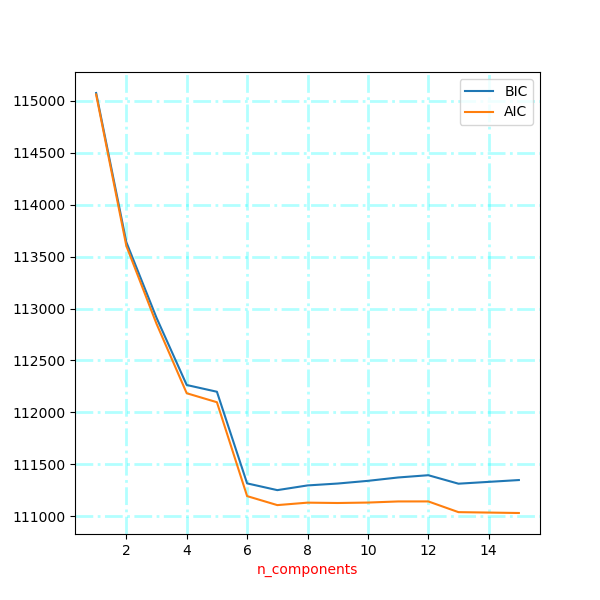

Number of components is: 6


In [21]:
# GMM number of componnents
from sklearn import mixture
tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)

mask = np.random.randint(0, len(tt), 10000)
tt = tt[mask]

n_components = np.arange(1, 16)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(tt)
          for n in n_components]

fig1, ax1 = plt.subplots(figsize=(6, 6))
bic_test = [m.bic(tt) for m in models]
aic_test = [m.aic(tt) for m in models]
plt.plot(n_components, bic_test, label='BIC')
plt.plot(n_components, aic_test, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components', color='r')
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.show()
n_components = min(np.argmin(bic_test), np.argmin(aic_test))
print('Number of components is:', n_components)

(1000, 2)


C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1000, 2)


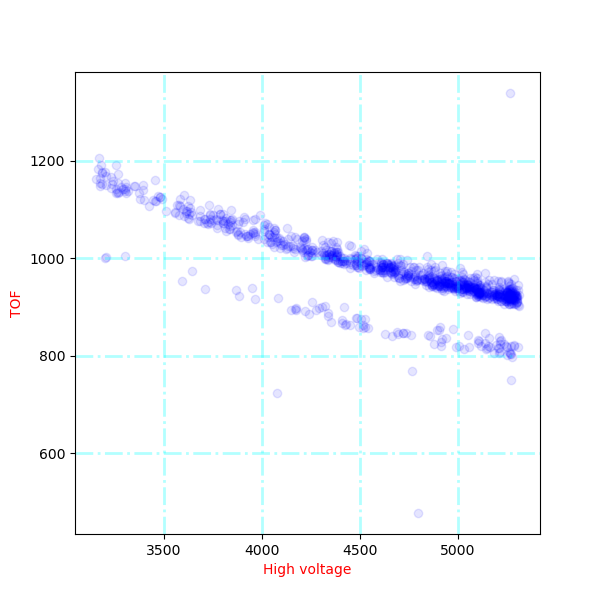

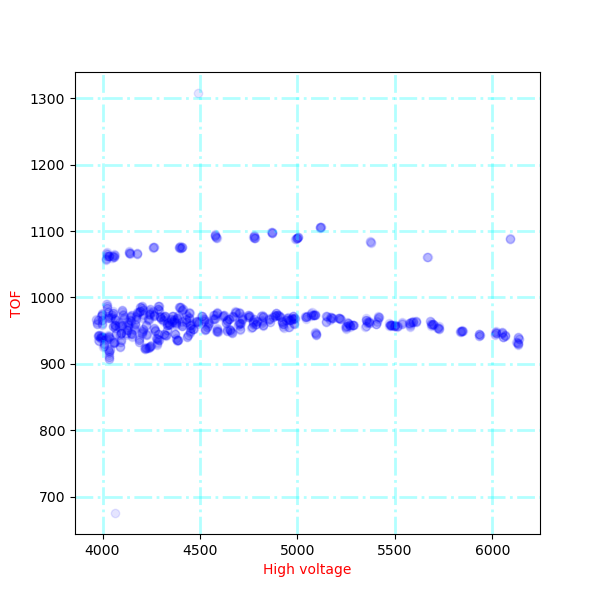

In [22]:
import numpy as np
from sklearn.manifold import TSNE

vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1)), axis=1)

mask = np.random.randint(0, len(vertices), 1000)
vertices = vertices[mask]
mean = vertices.mean(axis=0)
vertices = vertices - mean
print(vertices.shape)


X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto', metric="manhattan",
                   init='pca', perplexity=3).fit_transform(vertices)
print(X_embedded.shape)

X_embedded[:, 0] = X_embedded[:, 0] + mean[0]
X_embedded[:, 1] = X_embedded[:, 1] + mean[1]
vertices = vertices + mean

fig1, ax1 = plt.subplots(figsize=(6, 6))

x = plt.scatter(vertices[:,0], vertices[:,1], color="blue",
                label='t', alpha=0.1)
plt.xlabel('High voltage', color='r')
plt.ylabel('TOF', color='r')
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
fig1, ax1 = plt.subplots(figsize=(6, 6))

y = plt.scatter(X_embedded[:,0], X_embedded[:,1], color="blue",
                label='t', alpha=0.1)
plt.xlabel('High voltage', color='r')
plt.ylabel('TOF', color='r')
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

(1000, 4)


C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1000, 3)


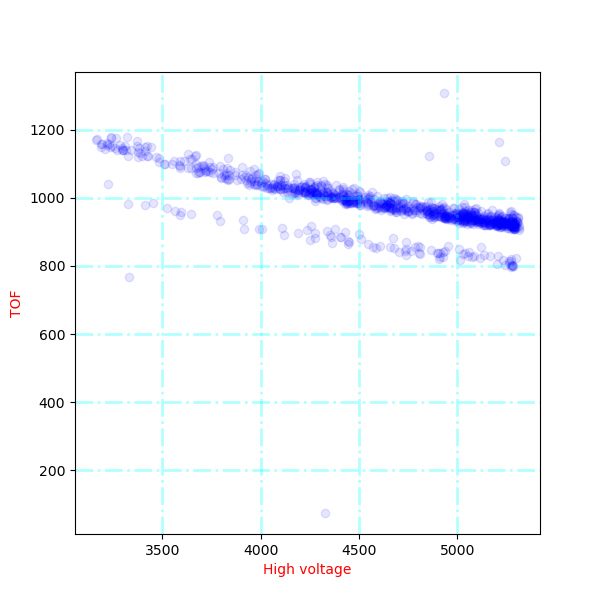

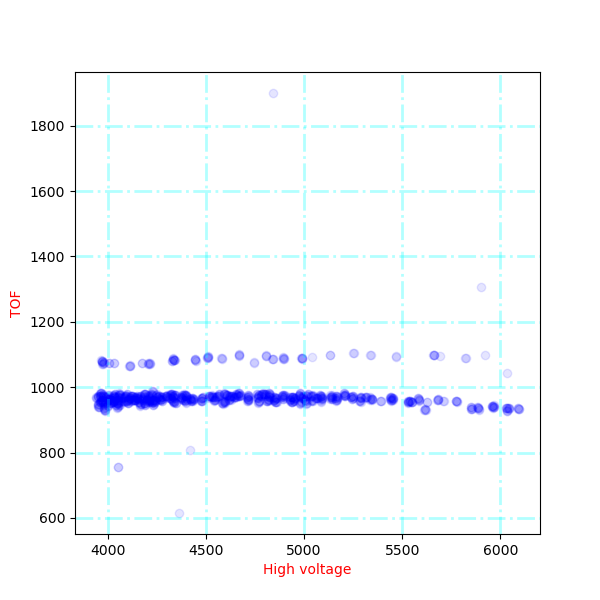

In [24]:
import numpy as np
from sklearn.manifold import TSNE

vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1), np.expand_dims(dld_x[dld_t < 1500], axis=1), np.expand_dims(dld_y[dld_t < 1500], axis=1)), axis=1)

mask = np.random.randint(0, len(vertices), 1000)
vertices = vertices[mask]
mean = vertices.mean(axis=0)
vertices = vertices - mean
print(vertices.shape)


X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=3, learning_rate='auto', metric="manhattan",
                   init='pca', perplexity=3).fit_transform(vertices)
print(X_embedded.shape)


X_embedded[:, 0] = X_embedded[:, 0] + mean[0]
X_embedded[:, 1] = X_embedded[:, 1] + mean[1]
vertices = vertices + mean

fig1, ax1 = plt.subplots(figsize=(6, 6))

x = plt.scatter(vertices[:,0], vertices[:,1], color="blue",
                label='t', alpha=0.1)
plt.xlabel('High voltage', color='r')
plt.ylabel('TOF', color='r')
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
fig1, ax1 = plt.subplots(figsize=(6, 6))

y = plt.scatter(X_embedded[:,0], X_embedded[:,1], color="blue",
                label='t', alpha=0.1)
plt.xlabel('High voltage', color='r')
plt.ylabel('TOF', color='r')
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

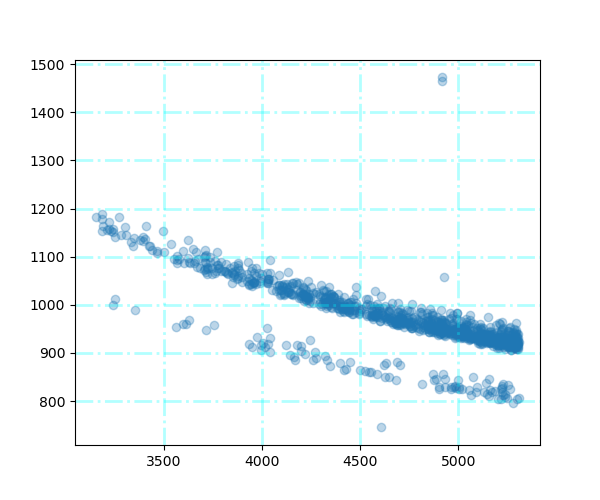

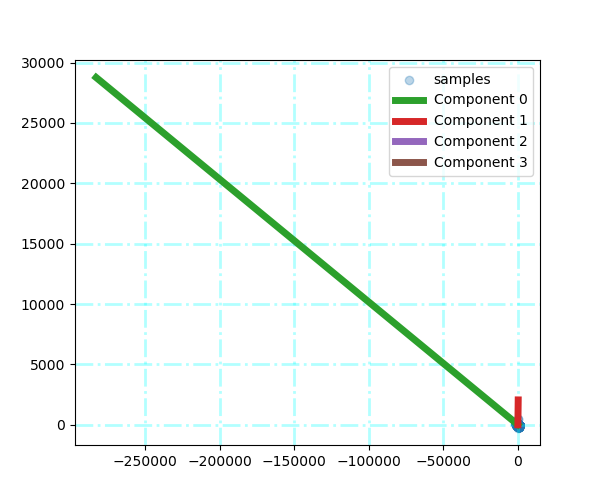

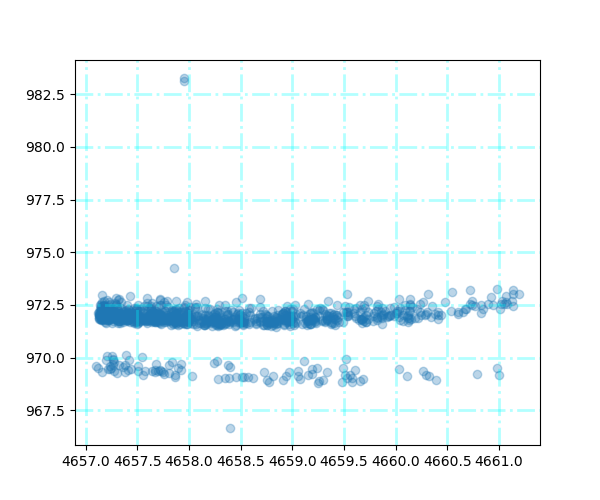

In [25]:
from sklearn.decomposition import PCA

vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1), np.expand_dims(dld_x[dld_t < 1500], axis=1), np.expand_dims(dld_y[dld_t < 1500], axis=1)), axis=1)
# vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1)), axis=1)

mask = np.random.randint(0, len(vertices), 1000)
vertices = vertices[mask]
mean = vertices.mean(axis=0)
vertices = vertices - mean

pca = PCA(n_components=4, whiten=True)
pca.fit(vertices)




plt.figure(figsize=(6, 5))
ver = vertices + mean
plt.scatter(ver[:, 0], ver[:, 1], alpha=0.3, label="samples")
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(vertices[:, 0], vertices[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )

plt.legend()
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.show()

X_pca = pca.transform(vertices)
X_pca = X_pca + mean[:4]
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.show()

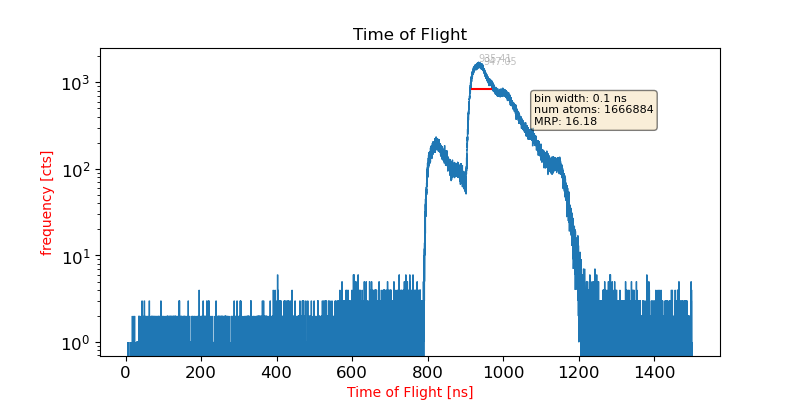

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 16.175027840253147
Peaks  0 is at location and height: (935.41, 1719.00) peak window sides (50.00%) are: (913.81, 971.64)
Peaks  1 is at location and height: (947.05, 1587.00) peak window sides (50.00%) are: (946.95, 947.05)


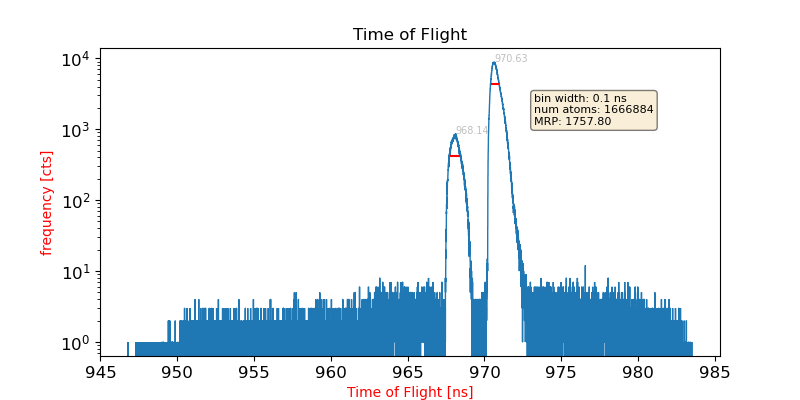

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 1757.7987703133797
Peaks  0 is at location and height: (968.14, 868.00) peak window sides (50.00%) are: (967.73, 968.42)
Peaks  1 is at location and height: (970.63, 8865.00) peak window sides (50.00%) are: (970.40, 970.95)


In [26]:
vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1), np.expand_dims(dld_x[dld_t < 1500], axis=1), np.expand_dims(dld_y[dld_t < 1500], axis=1)), axis=1)
# vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1)), axis=1)

mean = vertices.mean(axis=0)
vertices = vertices - mean

dld_t_pca = pca.transform(vertices)
dld_t_pca = dld_t_pca + mean[:4]
dld_t_pca = dld_t_pca[:, 1]

percent_mrp = 50
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t[dld_t < 1500], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='tof', fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))
    
percent_mrp = 50
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t_pca[dld_t_pca < 1500], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='tof', fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [83]:
mean

array([ 970.49313798, 4649.98381602])

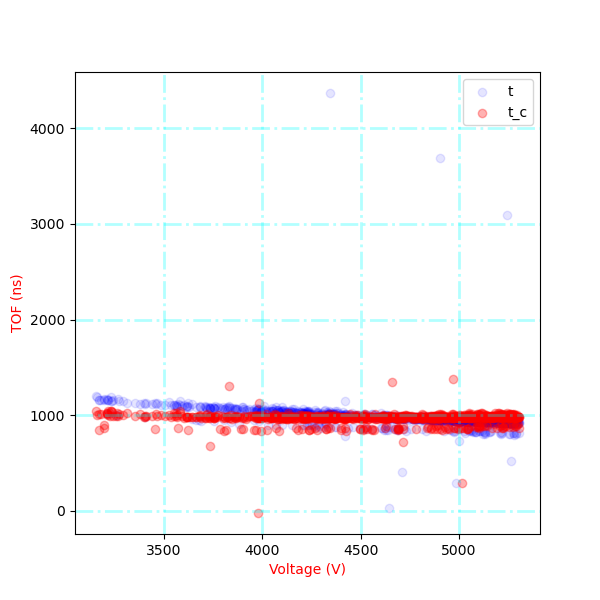

In [86]:
from scipy import linalg
# for i in range(1):
vertices = np.concatenate((np.expand_dims(dld_t[dld_t < 1500], axis=1), np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1)), axis=1)
mean = vertices.mean(axis=0)
vc = vertices - mean
# idx = np.random.randint(len(vertices), size=100000)
# vc_s = vc[idx, :]
# vertices = np.float32(vertices)

U, S, Vt = np.linalg.svd(vc, full_matrices=False)
vr = vc @ Vt.T
# dld_t_svd = np.expand_dims(dld_t[dld_t < 1500], axis=1) @ np.expand_dims(Vt[:, 0], axis=1).T
# dld_t_svd = np.sum(dld_t_svd, axis=1)

vr = vr 

dld_t_c_2 = vr[:, 1] + mean[0]

# data_2 = data.copy()
# data_2['t (ns)'] = vr[:, 0]
# data_loadcrop.plot_crop_experimetn_history(data_2, save_name=variables.result_path + '//ex_hist_pca' + dataset_name)

fig1, ax1 = plt.subplots(figsize=(6, 6))
mask = np.random.randint(0, len(dld_t_c_2), 1000)

x = plt.scatter(dld_highVoltage[mask], dld_t[mask], color="blue",
                label='t', alpha=0.1)
y = plt.scatter(dld_highVoltage[mask], dld_t_c_2[mask], color="red",
                label='t_c', alpha=0.3)

# z = plt.scatter(dld_highVoltage[mask], dld_t_svd[mask], color="green",
#                 label='t_svd', alpha=0.1)

# dld_t_p_c_2 = dld_t_c_2[mask_t]
# z = plt.scatter(dld_highVoltage_p_c[mask], dld_t_p_c_2[mask], color="black",
#                 label='t_c_2', alpha=0.1)

ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
ax1.set_ylabel("TOF (ns)", color="red", fontsize=10)
plt.legend()
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)




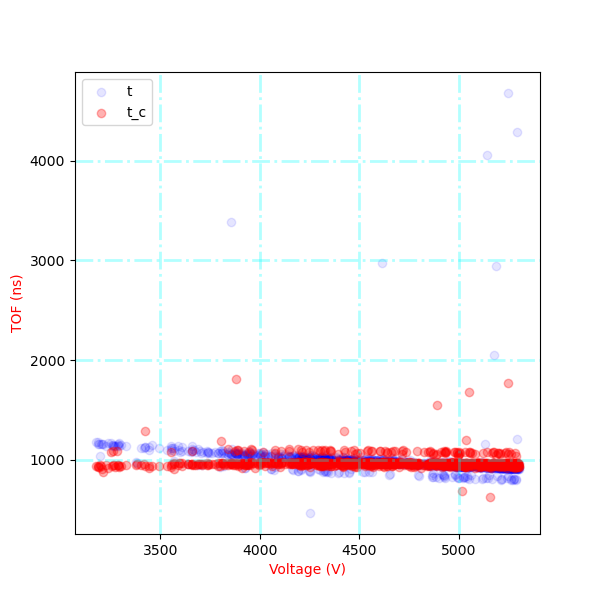

In [67]:
from scipy import linalg
# for i in range(1):
vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1)), axis=1)
mean = vertices.mean(axis=0)
vc = vertices - mean
# idx = np.random.randint(len(vertices), size=100000)
# vc_s = vc[idx, :]
# vertices = np.float32(vertices)

U, S, Vt = np.linalg.svd(vc, full_matrices=False)
vr = vc @ Vt.T
# dld_t_svd = np.expand_dims(dld_t[dld_t < 1500], axis=1) @ np.expand_dims(Vt[:, 0], axis=1).T
# dld_t_svd = np.sum(dld_t_svd, axis=1)

vr = vr + mean

dld_t_c_2 = vr[:, 1]

# data_2 = data.copy()
# data_2['t (ns)'] = vr[:, 0]
# data_loadcrop.plot_crop_experimetn_history(data_2, save_name=variables.result_path + '//ex_hist_pca' + dataset_name)

fig1, ax1 = plt.subplots(figsize=(6, 6))
mask = np.random.randint(0, len(dld_t_c_2), 1000)

x = plt.scatter(dld_highVoltage[mask], dld_t[mask], color="blue",
                label='t', alpha=0.1)
y = plt.scatter(dld_highVoltage[mask], dld_t_c_2[mask], color="red",
                label='t_c', alpha=0.3)

# z = plt.scatter(dld_highVoltage[mask], dld_t_svd[mask], color="green",
#                 label='t_svd', alpha=0.1)

# dld_t_p_c_2 = dld_t_c_2[mask_t]
# z = plt.scatter(dld_highVoltage_p_c[mask], dld_t_p_c_2[mask], color="black",
#                 label='t_c_2', alpha=0.1)

ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
ax1.set_ylabel("TOF (ns)", color="red", fontsize=10)
plt.legend()
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)




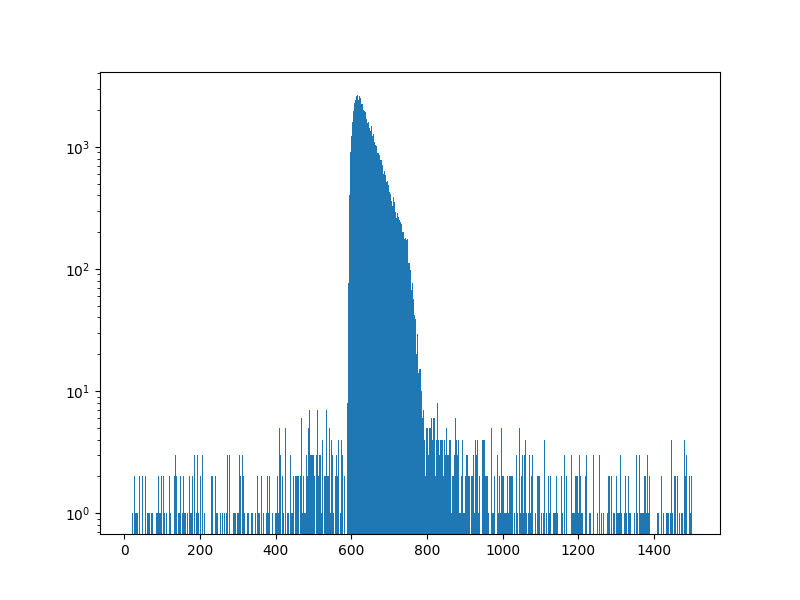

TypeError: '<=' not supported between instances of 'str' and 'int'

In [101]:
# K-means
from sklearn.cluster import KMeans

tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)
bins = 0.1
num_k = 4
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))
fig1, ax1 = plt.subplots(figsize=(8, 6))
plt.hist(tt, bins, log=True)
plt.show()




kmeans = KMeans(n_clusters=n_components, random_state=0, n_init="auto").fit(tt)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.hist(centers,bins, color='black')
plt.show()
print(centers)

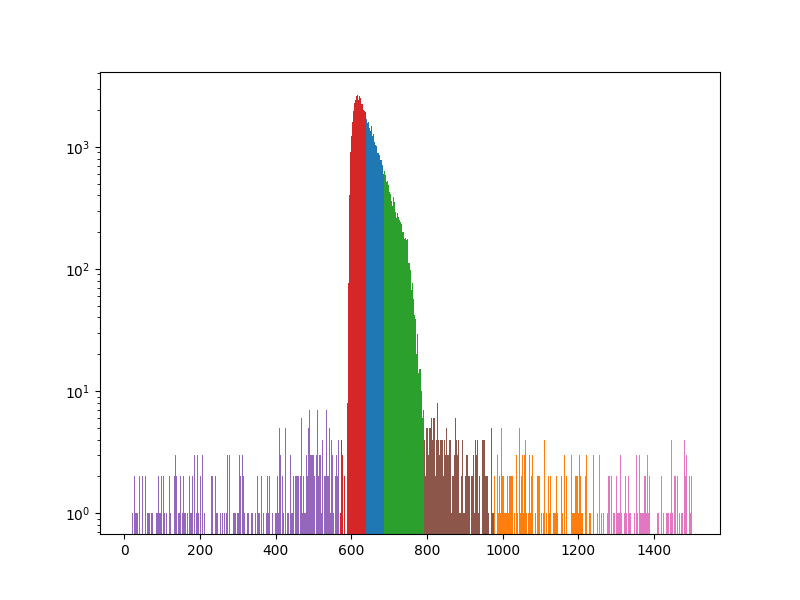

In [103]:
tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)

# n_components = 7
bins = 0.1
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))

gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(tt)
labels = gmm.predict(tt)


fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(n_components):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.show()

In [93]:
vertices = np.concatenate((np.expand_dims(dld_highVoltage[dld_t < 1500], axis=1), np.expand_dims(dld_t[dld_t < 1500], axis=1), np.expand_dims(dld_x[dld_t < 1500], axis=1), np.expand_dims(dld_y[dld_t < 1500], axis=1)), axis=1)

mask = np.random.randint(0, len(vertices), 10)
vertices = vertices[mask]

# mean = vertices.mean(axis=0)
# vertices = vertices - mean

tt = np.float32(vertices)
print(tt.shape)

gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(tt)
labels = gmm.predict(tt)


fig1, ax1 = plt.subplots(figsize=(8, 6))
bins = 0.1
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))
for i in range(n_components):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.show()

(10, 4)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000026F92512B80> (for post_execute):



KeyboardInterrupt



Estimated coefficients (true, linear regression, RANSAC):
[[-0.04237693]] [[-0.0901757]]


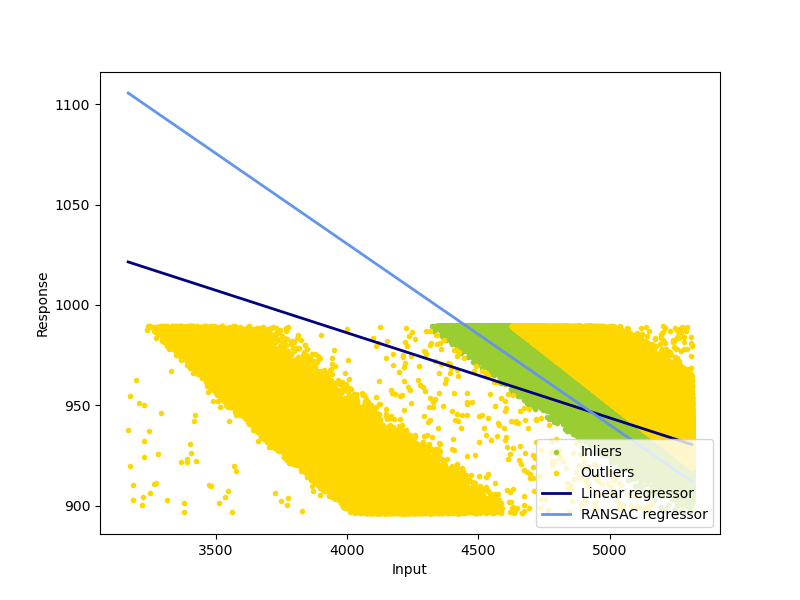

In [112]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets

mask = np.logical_and((dld_t < variables.selected_x2), (dld_t > variables.selected_x1))

y = np.expand_dims(dld_t[mask], axis=1)
X = np.expand_dims(dld_highVoltage[mask], axis=1)
# n_samples = 1000
# n_outliers = 50


# X, y, coef = datasets.make_regression(
#     n_samples=n_samples,
#     n_features=1,
#     n_informative=1,
#     noise=10,
#     coef=True,
#     random_state=0,
# )

# # Add outlier data
# np.random.seed(0)
# X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
# y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

fig1, ax1 = plt.subplots(figsize=(8, 6))
lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

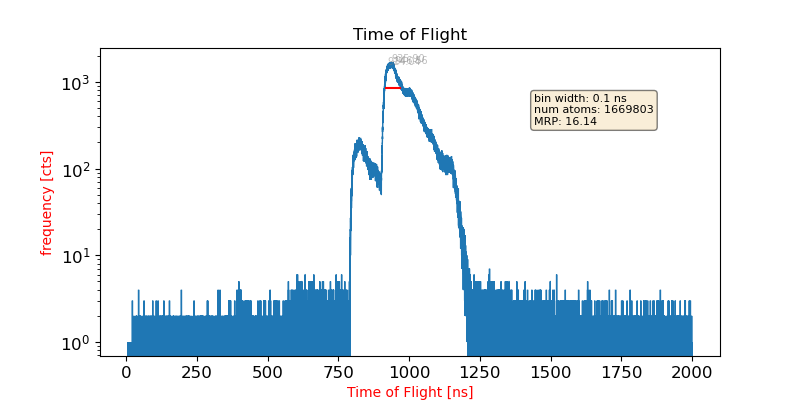

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 16.136784524553565
Peaks  0 is at location and height: (924.04, 1573.00) peak window sides (50.00%) are: (923.94, 924.04)
Peaks  1 is at location and height: (935.90, 1694.00) peak window sides (50.00%) are: (913.67, 971.67)
Peaks  2 is at location and height: (946.56, 1588.00) peak window sides (50.00%) are: (946.46, 946.56)


In [87]:
percent_mrp = 50
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t[dld_t < 2000], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='tof', fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

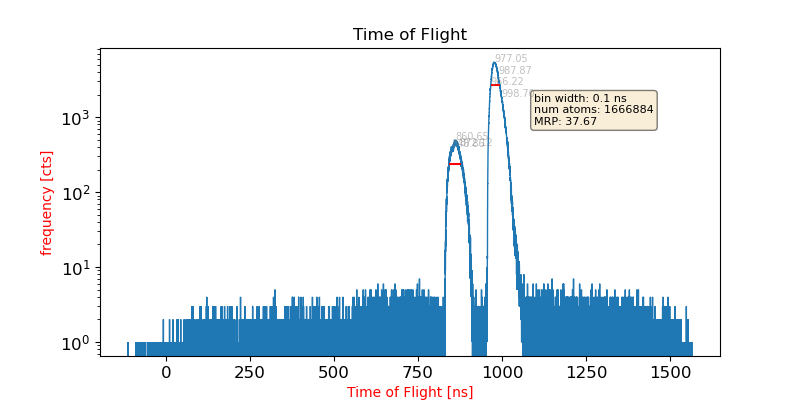

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 37.6705531335522
Peaks  0 is at location and height: (848.86, 405.00) peak window sides (50.00%) are: (848.76, 848.86)
Peaks  1 is at location and height: (860.65, 496.00) peak window sides (50.00%) are: (843.18, 876.73)
Peaks  2 is at location and height: (872.12, 406.00) peak window sides (50.00%) are: (872.01, 872.12)
Peaks  3 is at location and height: (966.22, 2669.00) peak window sides (50.00%) are: (966.11, 966.22)
Peaks  4 is at location and height: (977.05, 5441.00) peak window sides (50.00%) are: (966.44, 992.37)
Peaks  5 is at location and height: (987.87, 3716.00) peak window sides (50.00%) are: (987.76, 987.87)
Peaks  6 is at location and height: (998.70, 1837.00) peak window sides (50.00%) are: (998.59, 998.80)


In [94]:
percent_mrp = 50
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t_c_2[dld_t_c_2 < 2000], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='tof', fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [416]:
# mc = data['mc_c (Da)'].to_numpy()
# peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc[mc < 150], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
# index_max_ini = np.argmax(peaks_y_ini)
# mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
# print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
# for i in range(len(peaks_ini)):
#     print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

In [ ]:
percent_mrp = 50
lim = 150
mc_seb_ini = mc_tools.tof2mc(dld_t, 54, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, 110, mode=pulse_mode.value)
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_seb_ini[mc_seb_ini < lim], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

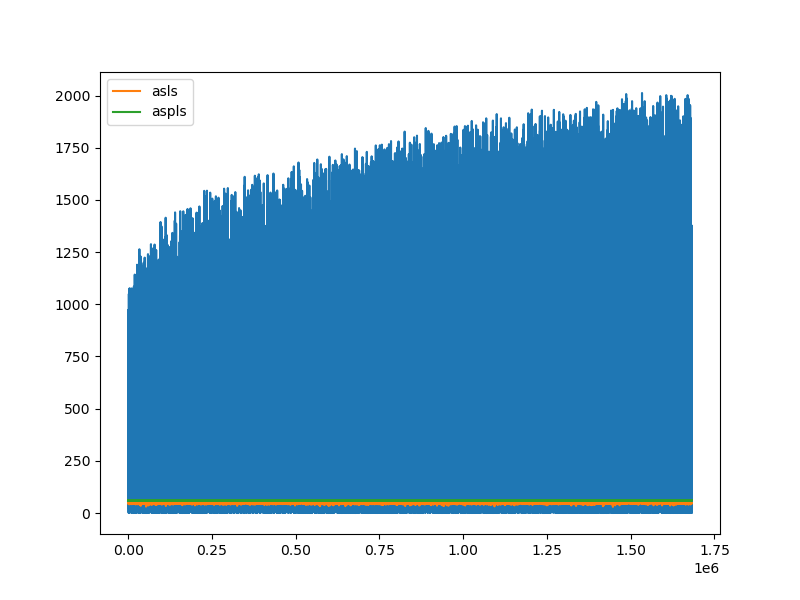

In [51]:
from pybaselines import Baseline



x = np.linspace(0, len(mc_seb_ini), len(mc_seb_ini))
baseline_fitter = Baseline(x_data=x)

lam = 5e6
tol = 1e-3
max_iter = 20
fit_1, params_1 = baseline_fitter.asls(mc_seb_ini, lam=lam, tol=tol, max_iter=max_iter)
fit_2, params_2 = baseline_fitter.aspls(mc_seb_ini, lam=lam, tol=tol, max_iter=max_iter)

fig1, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(mc_seb_ini)
plt.plot(fit_1, label='asls')
plt.plot(fit_2, label='aspls')
plt.legend()

In [95]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=500, description='peak distance:')
lim_tof=widgets.IntText(value=1500, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector = 'rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_tof_p], bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p, selector=selector, plot=plot, label='tof', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [96]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, det_diam.value, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [97]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p)


In [114]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset back correction',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')
    
@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    with out:
        clear_output(True)
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2)) 
            mask_temporal = np.logical_and((variables.dld_t_calib > variables.selected_x1),
                                           (variables.dld_t_calib < variables.selected_x2))
            x = dld_x[mask_temporal]
            y = dld_y[mask_temporal]
            bin_fdm_p = bin_fdm.value
            bins = [bin_fdm_p, bin_fdm_p]

            calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib = np.copy(variables.dld_t_calib_backup)
@save_button.on_click
def save_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_bowl.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  
        pb_bowl.value = "<b>Flished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_vol.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            vol_correction(dld_highVoltage, figname)
        pb_vol.value = "<b>Flished</b>"
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_button])]))
out = Output()
display(out)

Output()

In [443]:
fitresult = [ 1.59856266e+00,  5.68765920e-09, -1.41281563e-04]
f_v = calibration.voltage_corr(data['high_voltage (V)'].to_numpy(), *fitresult)
variables.dld_t_calib = variables.dld_t_calib * (1 / f_v)

In [189]:
parameters = [ 9.88684464e-01, -2.17639093e-04 , 2.36038428e-04,  3.44156992e-05, -2.62895576e-06,  3.28072030e-05]
f_bowl = calibration.bowl_corr_fit([data['x_det (cm)'].to_numpy()* 10, data['y_det (cm)'].to_numpy()* 10], *parameters)
variables.dld_t_calib = variables.dld_t_calib * 1 / f_bowl

In [165]:
variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)

In [190]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='tof', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
                   print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [89]:
interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_dld_t=widgets.IntText(value=1500)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [58]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b,)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [64]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [170.16256357 445.82940123 603.93536328]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [65]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal, maxfev=2000, bounds=(0, [100., 10., 10.0]))
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(variables.dld_t_calib, *fitresult)

C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [66]:
print('The t0 is:', fitresult[0], 'ns')

The t0 is: 65.16640169042097 ns


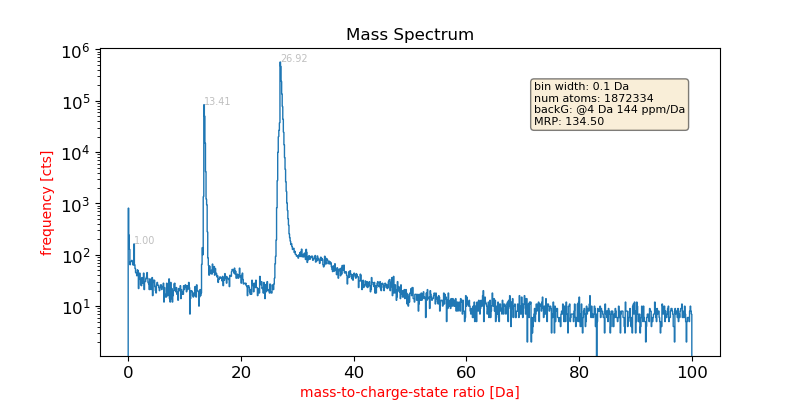

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 32.50801006573998
Peaks  0 is at location and height: (0.51, 181.00) peak window sides (half-maximum) are: (0.41, 0.51)
Peaks  1 is at location and height: (17.72, 25301.00) peak window sides (half-maximum) are: (17.22, 17.92)
Peaks  2 is at location and height: (32.53, 160475.00) peak window sides (half-maximum) are: (31.93, 32.93)


In [67]:
percent_mrp = 50
peak_p, peaks_y_p, peak_widths_p = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=percent_mrp, plot=True, fig_name='mc2_p_1'+figname)
index_max_ini = np.argmax(peaks_y_p)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [68]:
data['t_c (ns)'] = variables.dld_t_calib
data['mc_c (Da)'] = mc_p_1

In [69]:
# Remove negative mc
threshold = 0
mc_t = data['mc_c (Da)'].to_numpy()
mc_t_mask = (mc_t <= threshold)
data.drop(np.where(mc_t_mask)[0], inplace=True)
data.reset_index(inplace=True, drop=True)

In [70]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp,t_c (ns)
0,0.0,0.0,0.0,27.249972,27.322782,5276.637207,5276.637207,36631.0,625.106700,0.0,-0.022286,-1.177959,0,1,606.543112
1,0.0,0.0,0.0,27.141871,27.702932,5276.637207,5276.637207,36636.0,632.451618,0.0,-1.305306,1.056980,5,1,605.468210
2,0.0,0.0,0.0,13.418996,13.920760,5276.637207,5276.637207,36651.0,473.983812,0.0,-2.881224,-0.986939,15,1,445.070772
3,0.0,0.0,0.0,26.970846,26.875930,5276.637207,5276.637207,37036.0,624.407184,0.0,0.687673,-1.626857,385,1,603.763243
4,0.0,0.0,0.0,13.433636,13.786519,5276.637207,5276.637207,37438.0,468.662004,0.0,2.110776,1.671429,402,1,445.277958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912331,0.0,0.0,0.0,27.051868,27.118839,5712.145508,5712.145508,33051.0,615.039156,0.0,2.403673,1.435837,191,1,604.571634
1912332,0.0,0.0,0.0,27.120636,27.778914,5712.145508,5712.145508,33404.0,615.800394,0.0,-0.735429,2.139429,353,1,605.256815
1912333,0.0,0.0,0.0,26.997048,27.357361,5712.145508,5712.145508,33490.0,607.179888,0.0,-1.563184,-0.856408,86,1,604.024801
1912334,0.0,0.0,0.0,26.963850,27.497484,5712.145508,5712.145508,33526.0,604.217232,0.0,-0.382041,1.041061,36,1,603.693388


In [71]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

In [72]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data, path=variables.result_path, name=dataset_name + '.POS')

In [128]:
# save data in csv format
data_tools.store_df_to_csv(data, variables.result_path + dataset_name + '.csv')